# Experiment with full training set
In this notebook we analyse the results when the full training set is used. This is the simplest unit of our experiments. This is a subset of the training sets experiment.

In [1]:
import os
import sys
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro, chi2
from sklearn.linear_model import LinearRegression

ROOTDIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
REPORTDIR = os.path.join(ROOTDIR, "report")
DATADIR = os.path.join(ROOTDIR, "data")
sys.path.insert(0, ROOTDIR)


In [2]:
import glob
from src.data import process

batch1 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-training-sets-*-25.csv"))]
batch2 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-training-sets-*-25-2.csv"))]

batch1 = pd.concat(batch1)
batch2 = pd.concat(batch2)

# we need to reset the `iteration` column for the second batch
# since we use this column as the index when calculating the
# correlation (see correlation cell below) & we cannot have
# duplicates in this column
batch2["iteration"] = batch2["iteration"] + 25
data = pd.concat([batch1, batch2])
data.shape

(60000, 25)

In [3]:
# preprocessing the data prior to analysis
# 1. fairness metrics are only calculated when privileged == None
# 2. scale fairness metrics according to zhang2021ignorance paper
# 3. combine dataset_label & protected
# 4. set the index to iteration
# 4. drop unused columns
# 4. rename column names
# 4. rename model names
data = data[data["privileged"] == "None"]
data = data[data["frac"] == data["frac"].max()]
process(data)
data["dataset_label"] = data["dataset_label"] + "-" + data["protected"].str.lower()
data = data.rename(columns={
    "dataset_label": "dataset",
    "disparate_impact": "DI",
    "statistical_parity_difference": "SPD",
})
data = data.set_index("iteration")
data = data[[
    "DI",
    "SPD",
    "frac",
    "model",
    "dataset",
]]
data.loc[(data["model"] == "logisticregression"), "model"] = "LR"
data.loc[(data["model"] == "randomforestclassifier"), "model"] = "RF"
data.loc[(data["model"] == "adaboostclassifier"), "model"] = "ADA"
data.loc[(data["model"] == "decisiontreeclassifier"), "model"] = "DT"

# data.loc[(data["dataset"] == "german-age"), "dataset"] = "GA"
# data.loc[(data["dataset"] == "german-sex"), "dataset"] = "GS"
# data.loc[(data["dataset"] == "compas-race"), "dataset"] = "CR"
# data.loc[(data["dataset"] == "compas-sex"), "dataset"] = "CS"
# data.loc[(data["dataset"] == "meps-race"), "dataset"] = "MR"
# data.loc[(data["dataset"] == "bank-age"), "dataset"] = "BA"
# data.loc[(data["dataset"] == "adult-race"), "dataset"] = "AR"
# data.loc[(data["dataset"] == "adult-sex"), "dataset"] = "AS"

data.shape

(2000, 5)

In [4]:
data.dtypes

DI         float64
SPD        float64
frac       float64
model       object
dataset     object
dtype: object

## Data validation

In this section I am performing some data quality checks to ensure that the data collection scripts worked as expected.

In [46]:
# here I am checking that we have data for the correct number of sub-subsets of the training set.

data.frac.unique()

array([1.])

In [4]:
# in this cell I am doing some manual checks to make
# sure I am sampling the data correctly by checking
# the shape of the dataset

# each vector should contain num_features*50 points

# order datasets by number of examples
datasets = ["german-age", "german-sex", "compas-race", "compas-sex", "meps-race", "bank-age", "adult-race", "adult-sex"]
models = data["model"].unique().tolist()
models.remove("None")

for dataset in datasets:
    _ = data[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50


    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50

In [48]:
# we should not have any missing values in DI & SPD
data.isna().any()

DI         False
SPD        False
frac       False
model      False
dataset    False
dtype: bool

# Shapiro-wilk test for normality
In this section we employ the Shapiro-Wilk test for normality. The test is as follows:

- $H_o$: the population is normally distributed
- $H_1$: the population is not normally distributed

We need to test for normality since statistical analysis & formuli used later in the analysis will depend on normality assumption.

In [17]:
pvalues = {
    "dataset": [],
    "model": [],
    "DI": [],
    "SPD": [],
}

for dataset in datasets:
    _ = data[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    pvalues["dataset"].append(dataset)
    pvalues["model"].append("None")
    pvalues["DI"].append(shapiro(_["DI"]).pvalue)
    pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
        pvalues["dataset"].append(dataset)
        pvalues["model"].append(model)
        pvalues["DI"].append(shapiro(_["DI"]).pvalue)
        pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

pvalues = pd.DataFrame(data=pvalues)
pvalues["DI"] = pvalues["DI"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues["SPD"] = pvalues["SPD"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues


,dataset,model,DI,SPD
0,german-age,None,,
1,german-age,LR,,
2,german-age,DT,*,
3,german-age,ADA,,
4,german-age,RF,,
5,german-sex,None,,
6,german-sex,LR,,
7,german-sex,DT,***,***
8,german-sex,ADA,**,**
9,german-sex,RF,,


Most of the populations are normally distributed.

# Distributional Analysis
In this section we analyse the distribution of the fairness metrics.

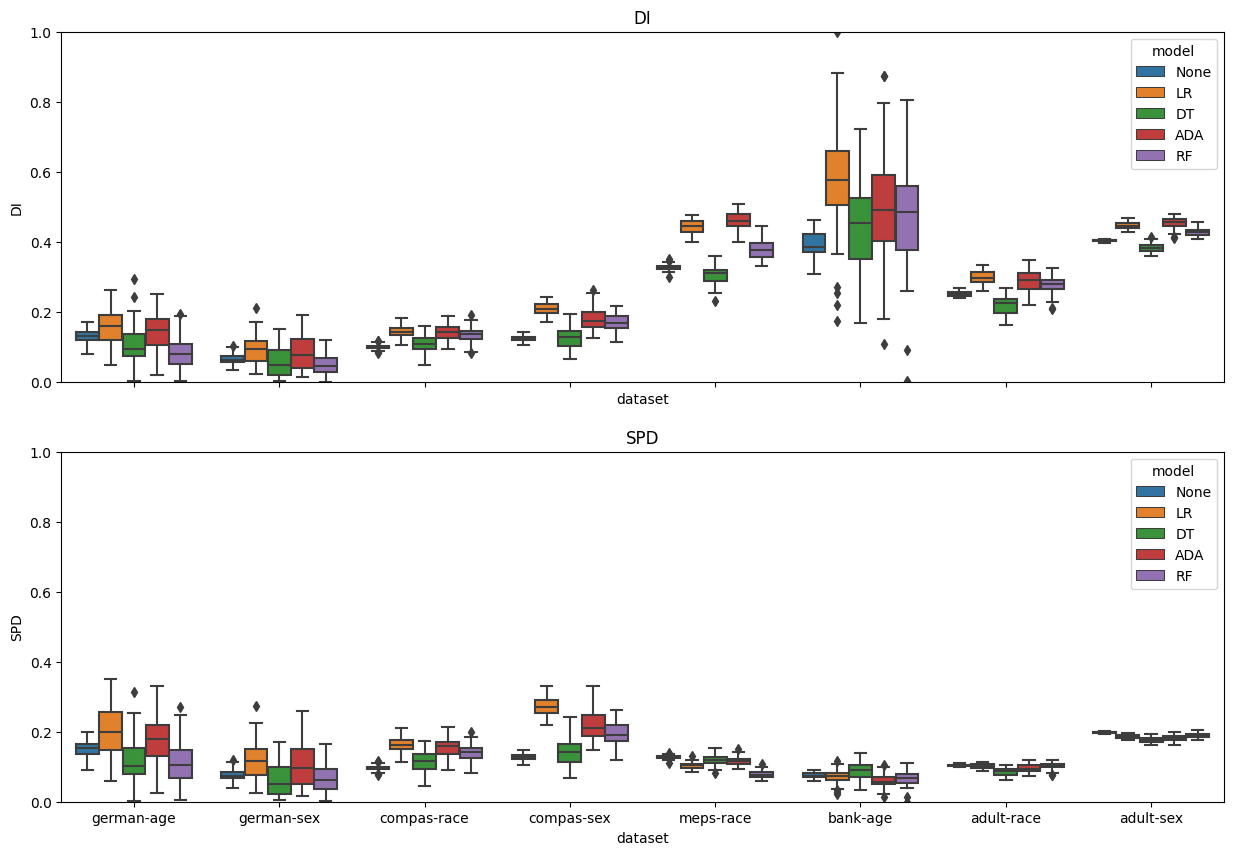

In [63]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15,10),
    sharex=True,
)

ax = axs[0]
ax.set_title("DI")
ax.set(ylim=(0, 1))
sns.boxplot(
    data=data,
    x="dataset",
    y="DI",
    hue="model",
    order=datasets,
    ax=ax,
)

ax = axs[1]
ax.set_title("SPD")
ax.set(ylim=(0, 1))
sns.boxplot(
    data=data,
    x="dataset",
    y="SPD",
    hue="model",
    order=datasets,
    ax=ax,
)

name = "boxplot--dataset--di-spd--exp-full.pdf"
fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "boxplot--dataset--di-spd--exp-full.png"
fig.savefig(os.path.join(REPORTDIR, name), format="png")

SPD is sensitive to the number of examples: we see that the variability is low in datasets with more number of examples. I cannot interpret the results for DI though, variability is low in all datasets except for bank-age which is strange because it is not that different from the other dataset?

The data fairness metrics are similar. These seems to be some variation in the model fairness metrics which can be attributed to the randomess in the initial state of the models.

The DFM & MFM convey the same information.

Tree based models (DT & RF) are more fair compared to other models.

We have some outliners which we need to consider when conducting linear regression analysis.

# Correlation

In [5]:
from scipy.stats import spearmanr

indices = [[
    "DI",
    "SPD",
],
models]
corr = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
corr_pvalues = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))

for d in datasets:
    _ = data[
        (data["dataset"] == d)
    ]
    for metric in ["DI", "SPD"]:
        pivoted = pd.pivot(
            data=_,
            columns="model",
            values=metric,
        )
        for model in models:
            c, p = spearmanr(pivoted[model], pivoted["None"])
            corr.loc[(metric, model), d] = c
            corr_pvalues.loc[(metric, model), d] = p

corr

german-age german-sex compas-race compas-sex meps-race  bank-age  \
metric model                                                                    
DI     LR     -0.017143  -0.114384    0.408115   0.303529 -0.145642  -0.07611   
       DT     -0.213504  -0.026411    0.143145   0.006963  -0.32072 -0.158703   
       ADA    -0.120243  -0.023818   -0.052293   0.182713 -0.210276 -0.174166   
       RF     -0.120291  -0.203304    0.170804   0.092437 -0.186074 -0.170516   
SPD    LR     -0.061322  -0.072799     0.40581   0.372485 -0.090132  -0.10982   
       DT     -0.212159   -0.03275    0.145834   0.010612 -0.357791  -0.19952   
       ADA    -0.131528   0.013014   -0.092053   0.141609 -0.251669   -0.1903   
       RF     -0.135177  -0.208202    0.230252   0.099256 -0.157839 -0.203938   

             adult-race adult-sex  
metric model                       
DI     LR      -0.39006 -0.168788  
       DT     -0.576759 -0.196639  
       ADA    -0.106363 -0.058151  
       RF      -0.31563 -0.368067  
SPD    LR     -0.433565 -0.059304  
       DT     -0.538247 -0.146699  
       ADA    -0.141128  0.020024  
       RF     -0.279232 -0.182041

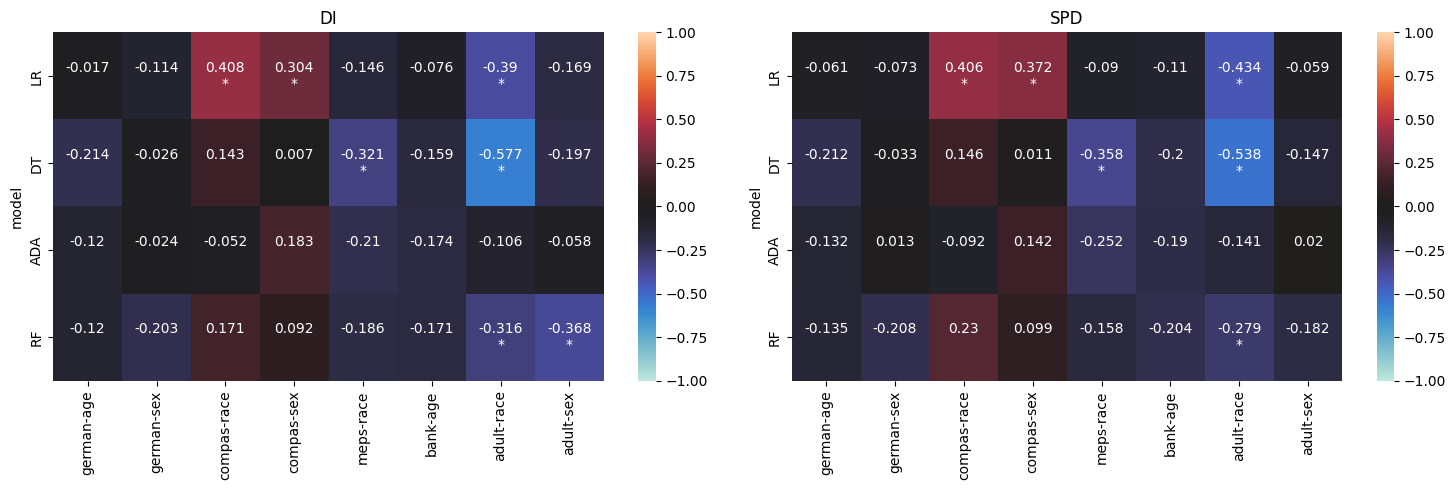

In [6]:
import numpy as np

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 5)
)

for idx, metric in enumerate(["DI", "SPD"]):
    ax = axs[idx]
    ax.set_title(metric)
    _ = corr.loc[(metric)].astype(float)
    _corr = _.round(3).astype(str)
    _sig = corr_pvalues.loc[(metric)].applymap(
        # lambda x: ''.join(['*' for t in [0.01, 0.05, 0.1] if x<=t])
        lambda x: ''.join(['*' for t in [0.05] if x<=t])
    )
    annot = _corr + "\n" + _sig
    sns.heatmap(
        data=_,
        annot=annot,
        fmt="",
        vmin=-1.,
        vmax=1.,
        center=0.,
        ax=ax,
    )

fig.tight_layout()

name = "heatmap--corr--full-data.pdf"
fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "heatmap--corr--full-data.png"
fig.savefig(os.path.join(REPORTDIR, name), format="png")

# Linear Regression

In [66]:

d = {
    "dataset": [],
    "model": [],
    "metric": [],
    "intercept": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
    "fvalue": [],
    "llf": [],
    "mse_model": [],
    "mse_resid": [],
    "mse_total": [],
    # "pvalues": [],
    "ssr": [],
    # "tvalues": [],
}

for dataset in datasets:
    for model in models:
        for metric in ["DI", "SPD"]:
            x = data.loc[
                (data["dataset"] == dataset) &
                (data["model"] == "None"),
                metric
            ].values.reshape(-1, 1)
            y = data.loc[
                (data["dataset"] == dataset) &
                (data["model"] == model),
                metric
            ].values.reshape(-1, 1)
            mod = sm.OLS(
                endog=y,
                exog=sm.tools.add_constant(x),
            )
            res = mod.fit()

            d["dataset"].append(dataset)
            d["model"].append(model)
            d["metric"].append(metric)
            d["intercept"].append(res.params[0])
            d["slope"].append(res.params[1])
            d["r2"].append(res.rsquared)
            d["f_pvalue"].append(res.f_pvalue)
            d["fvalue"].append(res.fvalue)
            d["llf"].append(res.llf)
            d["mse_model"].append(res.mse_model)
            d["mse_resid"].append(res.mse_resid)
            d["mse_total"].append(res.mse_total)
            d["ssr"].append(res.ssr)

reg = pd.DataFrame(data=d)
reg


,dataset,model,metric,intercept,slope,r2,f_pvalue,fvalue,llf,mse_model,mse_resid,mse_total,ssr
0,german-age,LR,DI,0.178921,-0.178345,0.003931,0.665338,0.189435,73.970205,5.994055e-04,0.003164,0.003112,0.151880
1,german-age,LR,SPD,0.241312,-0.288455,0.008477,0.524828,0.410371,60.625015,2.214453e-03,0.005396,0.005331,0.259019
2,german-age,DT,DI,0.207083,-0.799957,0.064489,0.075149,3.308845,70.436084,1.205954e-02,0.003645,0.003816,0.174943
3,german-age,DT,SPD,0.224856,-0.736263,0.062942,0.078855,3.224162,65.306794,1.442700e-02,0.004475,0.004678,0.214783
4,german-age,ADA,DI,0.198322,-0.437197,0.028471,0.241453,1.406641,79.259938,3.602065e-03,0.002561,0.002582,0.122916
5,german-age,ADA,SPD,0.245299,-0.459405,0.026159,0.261800,1.289380,65.976702,5.616978e-03,0.004356,0.004382,0.209104
6,german-age,RF,DI,0.134014,-0.384067,0.024034,0.282374,1.182022,81.388845,2.779783e-03,0.002352,0.002360,0.112882
7,german-age,RF,SPD,0.181288,-0.459595,0.027245,0.251994,1.344408,67.000882,5.621613e-03,0.004181,0.004211,0.200711
8,german-sex,LR,DI,0.107338,-0.251037,0.009621,0.497981,0.466291,89.168130,8.033464e-04,0.001723,0.001704,0.082696
9,german-sex,LR,SPD,0.130014,-0.188093,0.004262,0.652416,0.205429,74.917996,6.258308e-04,0.003046,0.002997,0.146230


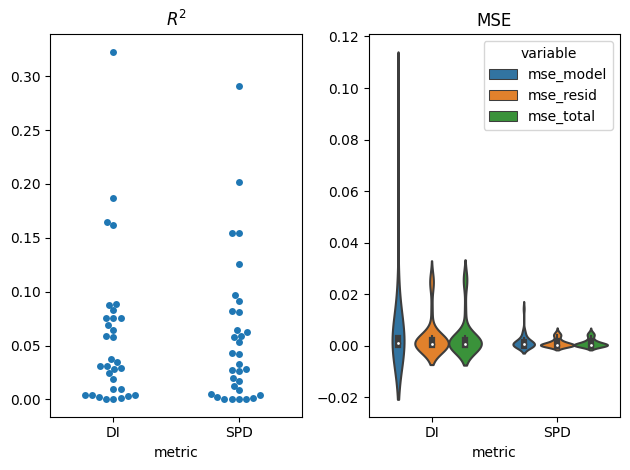

In [70]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)


ax = axs[0]
ax.set_title("$R^2$")
sns.swarmplot(
    data=reg,
    y="r2",
    x="metric",
    ax=ax,
)
ax.set_ylabel(None)

ax = axs[1]
ax.set_title("MSE")
_ = reg.loc[:, ["metric", "mse_model", "mse_resid", "mse_total"]]
_ = _.melt(id_vars=["metric"])
sns.violinplot(
    data=_,
    x="metric",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_ylabel(None)

fig.tight_layout()
# name = "violinplot--metric--r2-mse--full-data.pdf"
# fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

# name = "violinplot--metric--r2-mse--full-data.png"
# fig.savefig(os.path.join(REPORTDIR, name), format="png")

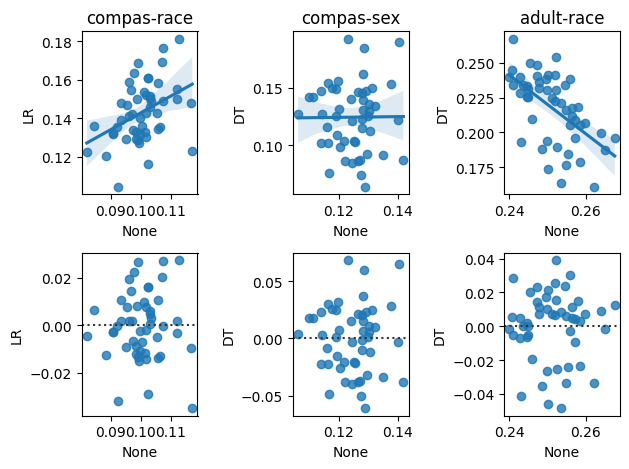

In [68]:
# linear regression fit and residuals for most positive, no &
# most negative correlations for DI

fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
)

# most positive: compas-race-LR
_ = data[data["dataset"] == "compas-race"]
pivoted = pd.pivot(
    data=_,
    columns="model",
    values="DI",
)

ax = axs[0, 0]
ax.set_title("compas-race")
sns.regplot(
    data=pivoted,
    x="None",
    y="LR",
    scatter=True,
    # robust=True,
    ax=ax,
)

ax = axs[1, 0]
sns.residplot(
    data=pivoted,
    x="None",
    y="LR",
    # robust=True,
    ax=ax,
)

# none: compas-sex-DT
_ = data[data["dataset"] == "compas-sex"]
pivoted = pd.pivot(
    data=_,
    columns="model",
    values="DI",
)

ax = axs[0, 1]
ax.set_title("compas-sex")
sns.regplot(
    data=pivoted,
    x="None",
    y="DT",
    scatter=True,
    # robust=True,
    ax=ax,
)

ax = axs[1, 1]
sns.residplot(
    data=pivoted,
    x="None",
    y="DT",
    # robust=True,
    ax=ax,
)

# most negative: adult-race-DT
_ = data[data["dataset"] == "adult-race"]
pivoted = pd.pivot(
    data=_,
    columns="model",
    values="DI",
)

ax = axs[0, 2]
ax.set_title("adult-race")
sns.regplot(
    data=pivoted,
    x="None",
    y="DT",
    scatter=True,
    # robust=True,
    ax=ax,
)

ax = axs[1, 2]
sns.residplot(
    data=pivoted,
    x="None",
    y="DT",
    # robust=True,
    ax=ax,
)

fig.tight_layout()
name = "linear-regression--full-data.pdf"
fig.savefig(os.path.join(REPORTDIR, name), format="pdf")

name = "linear-regression--full-data.png"
fig.savefig(os.path.join(REPORTDIR, name), format="png")
